In [1]:
import torch
import numpy as np
import normflows as nf

seed=66
torch.manual_seed(seed)
torch.no_grad()

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.join(c_directory, 'BSCD'))
sys.path.append(os.path.join(c_directory, 'FCYeast'))
sys.path.append(os.path.join(c_directory, 'FCYeast3'))

from matplotlib import pyplot as plt
import FC3_simulator

enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
target = FC3_simulator.target()
context_size = 6

latent_size = 1
hidden_units = 128
hidden_layers = 5

/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))
/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params_dist = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))


In [3]:
dils_str = ['12','23','33']
dils = [.12,.23,.33]
models=[]

for dil in dils_str:
    flows = [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 64,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 128,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),      
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 512,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size)
         ]
    model_file = c_directory+'/FCYeast3/dilution{}/FCYeast_network.pt'.format(dil)
    q0 = nf.distributions.DiagGaussian(1)
    model = nf.ConditionalNormalizingFlow(q0, flows, target)
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.load_state_dict(torch.load(model_file))
    models.append(model)

In [4]:
import pandas as pd

dils = [.12,.23,.33]

dfs = [pd.read_csv('clean_data/complete_d={}.csv'.format(d)) for d in dils]
x = [torch.tensor(df['FL1-A'].to_numpy().astype(np.float32)).reshape(-1,1).to(device) for df in dfs]


ind = torch.arange(0,x[0].size(0),10)
#if seed==42:
#    ind = torch.arange(0,x[0].size(0),10)
#else:
#    M = min([xi.size(0) for xi in x])
#    ind = torch.randperm(M)[:M//10]
#    ind = torch.sort(ind).values

x = [torch.log(xi[ind]) for xi in x]

In [5]:
def separate(x):
    return torch.tensor(((x[0],x[1],x[2],x[3],x[4],x[11]),
                         (x[0],x[1],x[5],x[6],x[7],x[11]),
                         (x[0],x[1],x[8],x[9],x[10],x[11]))).to(device)

to_hours = -torch.tensor(((0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_hour(x): #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all in hours
    return separate(x) + to_hours


to_arbitrary = -torch.tensor(((1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_arbitrary(x):  #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all to arbitrary
    return separate(x) + to_arbitrary
    

In [6]:
def logprior(params):
    return target.prior.log_prob(params)

vectorize_params = [torch.ones(xi.size(0),6).to(device) for xi in x]

def log_likelihood(data,params,models):
    global vectorize_params

    lp = []
    for (data_sub,params_sub,vec_params_sub,model_sub) in zip(data,params,vectorize_params,models):
        if data_sub.size !=  vec_params_sub.size(0):
            vec_params_sub = torch.ones((data_sub.size(0),6),device=device)
        lp.append(model_sub.log_prob(data_sub,params_sub*vec_params_sub))

    return lp

def log_post(data,params,models,lprior=logprior):
    return sum([lp.sum() for lp in log_likelihood(data,transform_to_arbitrary(params),models)]) + lprior(params)

In [7]:
params_100 = target.prior.sample((1000,))
params_100[:,0] -=1.
best_param = params_100[0]
lp_max = log_post(x,best_param,models)

for par in params_100[1:]:
    lp_par = log_post(x,par,models)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par
        print(best_param,lp_max)

for i in range(3,10):
    print(i)
    for par in (1/i)*(params_100-best_param) + best_param:
        lp_par = log_post(x,par,models)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 5.3590e-01,  9.1436e+00,  1.8593e-01,  6.8771e-01, -2.7838e+00,
        -1.8514e+00,  8.7082e-03, -2.5588e+00, -7.1621e-01, -4.6204e-01,
        -1.9367e+00, -1.8770e+00], device='cuda:0') tensor(-120990.9453, device='cuda:0')
tensor([ 1.4740,  7.1797,  0.4274,  0.2741, -2.1012, -0.8330,  0.2236, -2.5772,
        -0.0917, -0.3486, -2.2129, -3.5032], device='cuda:0') tensor(-91676.1797, device='cuda:0')
tensor([-0.1869,  6.5830, -0.7603,  1.0052, -1.9807, -0.5299,  1.4229, -2.3962,
        -0.3189,  0.2349, -2.5591, -2.3888], device='cuda:0') tensor(-70623.8281, device='cuda:0')
tensor([-0.6909,  6.2899, -0.8825,  2.2208, -2.1762, -2.1240,  0.4575, -2.1434,
        -0.0863,  1.1316, -2.3488, -2.2474], device='cuda:0') tensor(-65586.0078, device='cuda:0')
tensor([ 1.1299,  6.5057, -0.1354,  0.5264, -2.0390, -0.2262,  1.8631, -1.9532,
        -0.9193, -0.0327, -2.4030, -3.5530], device='cuda:0') tensor(-60090.9102, device='cuda:0')
tensor([ 1.8716,  6.5700, -0.1624,  0.2927, -1.9

In [8]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [9]:
S = torch.eye(12)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [10]:
count_of_safe=0
loopruns = 0

while count_of_safe <=15:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,models)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(12)*1e-8) * (2.4**2/(12)) )
    loopruns+=1

    print(loopruns,acc_rate, '    ', sampled_logpost[-1])
    



1 0.48      -43717.59765625
2 0.36      -42231.13671875
3 0.31      -41750.21484375
4 0.01      -41708.828125
5 0.04      -41705.90234375
6 0.02      -41697.796875
7 0.44      -41687.828125
8 0.44      -41683.60546875
9 0.44      -41686.078125
10 0.49      -41678.00390625
11 0.35      -41672.04296875
12 0.46      -41654.7734375
13 0.4      -41645.30078125
14 0.32      -41643.6171875
15 0.48      -41635.33203125
16 0.26      -41599.33203125
17 0.38      -41529.0390625
18 0.27      -41479.17578125
19 0.28      -41469.6640625
20 0.21      -41467.07421875
21 0.24      -41468.29296875
22 0.49      -41470.25


In [11]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,models)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 7.2369e-01,  6.6825e+00, -6.0169e-01,  1.1489e+00, -1.1985e+00,
        -2.2773e+00,  5.4966e-03, -2.1903e+00, -2.0983e+00,  2.0186e+00,
        -2.2159e+00, -3.1990e+00], device='cuda:0') tensor(-41468.9727, device='cuda:0')
199 tensor([ 0.7321,  6.6489, -0.5574,  1.1637, -1.1557, -2.2753,  0.0162, -2.2060,
        -2.0967,  2.0028, -2.1710, -3.1758], device='cuda:0') tensor(-41473.0273, device='cuda:0')
299 tensor([ 0.7252,  6.6664, -0.5642,  1.1526, -1.1764, -2.2974,  0.0223, -2.1923,
        -2.1331,  1.9509, -2.2266, -3.1778], device='cuda:0') tensor(-41466.7930, device='cuda:0')
399 tensor([ 0.7349,  6.6799, -0.5836,  1.1562, -1.1706, -2.2960,  0.0102, -2.1845,
        -2.1229,  1.9693, -2.2445, -3.1906], device='cuda:0') tensor(-41466.1406, device='cuda:0')
499 tensor([ 0.7688,  6.6668, -0.5416,  1.1776, -1.1605, -2.3037,  0.0417, -2.2098,
        -2.1108,  1.9873, -2.2004, -3.1830], device='cuda:0') tensor(-41469.4453, device='cuda:0')
599 tensor([ 0.7576,  6.6824, 

KeyboardInterrupt: 

In [21]:
np.savetxt('mcmc_real_results_{}seed.csv'.format(seed),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

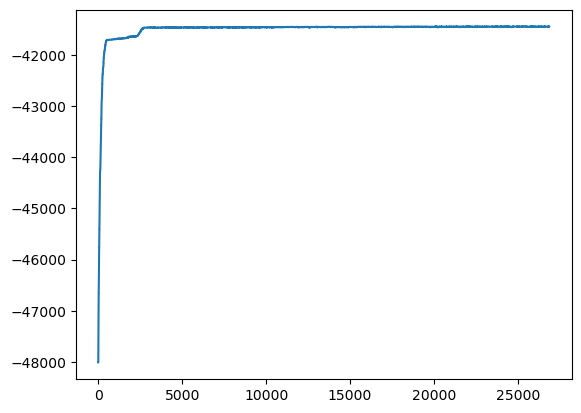

In [22]:
plt.plot(sampled_logpost)

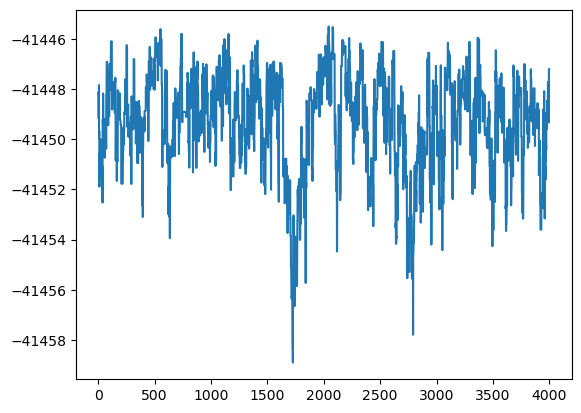

In [23]:
plt.plot(sampled_logpost[-4000:])

In [24]:

def grid_plot(x,param,model):
    xp = torch.linspace(x.min(),x.max(),101).to(device)
    lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*param)
    p = torch.exp(lp-lp.max())
    p *= 1/(p.sum()*(xp[1]-xp[0]))
    return xp.cpu(),p.cpu()




In [25]:
best_param = sampled_params[np.argmax(sampled_logpost)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


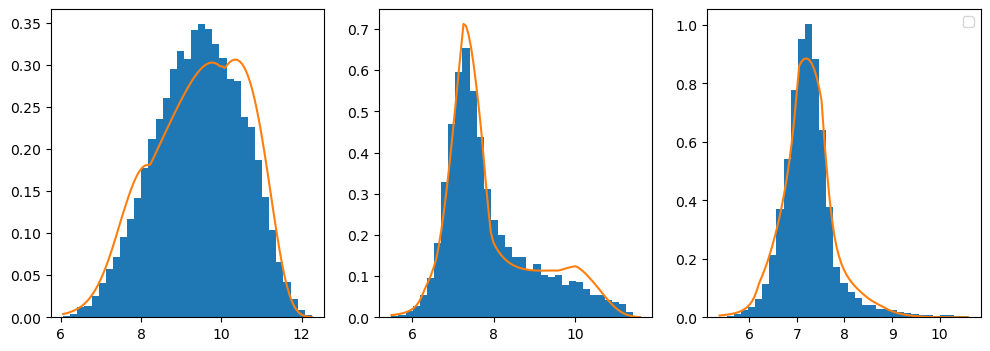

In [26]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]
params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
#[axi.hist(model.sample((10000,),parami),density=True,alpha=.4) for (xi,parami,axi,model) in zip(x,params,ax,models)]


plt.legend()

In [27]:
import FCYeast.FCYeast_simulator 
target = FCYeast.FCYeast_simulator.target()

In [28]:
target.sample(params[0,:2],params[0,2:4],params[0,4:5].reshape(-1),params[0,5:].reshape(-1),return_lparams=False).cpu().numpy()

array([10.36312 , 11.065017,  9.452903, ...,  9.94339 ,  8.505522,
        7.352842], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


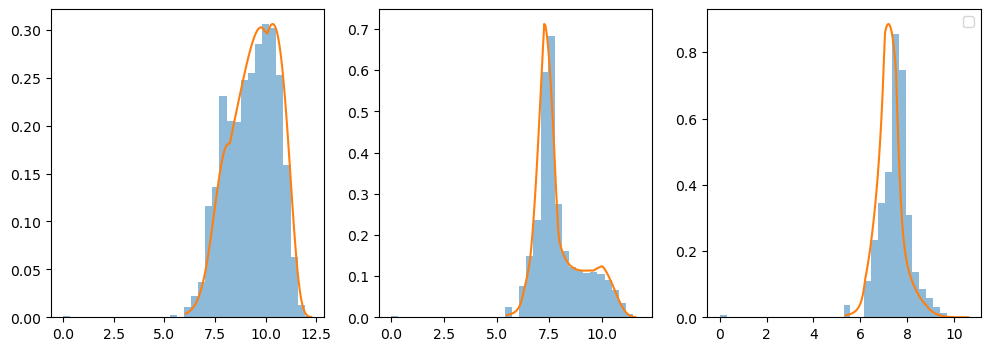

In [29]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
#[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]

[ax[i].hist(target.sample(params[i,:2],params[i,2:4],params[i,4:5].reshape(-1),params[i,5:].reshape(-1),n=2**16,return_lparams=False).cpu().numpy(),
          density=True,
          bins=35,alpha=.5) for i in range(3)]
params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
#[axi.hist(model.sample((10000,),parami),density=True,alpha=.4) for (xi,parami,axi,model) in zip(x,params,ax,models)]


plt.legend()